In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split

from ultralytics import YOLO

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
# Go to https://wandb.ai/, Login and generate your api key

wandb.login(key="Your-wandb-api-key")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: theonepiece (theonepiece-indian-institute-of-science). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/abhishek/.netrc


True

In [4]:
train_img_path='./train/images/'
train_lbl_path='./train/labels/'
val_img_path='./valid/images/'
val_lbl_path= './valid/labels/'
test_img_path='./test/images/'
test_lbl_path='./test/labels/'
model_path= './best.pt'
data_yaml_path= "./data.yaml"

In [5]:
# EDA and Data Preprocessing
def load_labels(label_path):
    label_files = os.listdir(label_path)
    data = []
    classes = set()
    for file in label_files:
        with open(os.path.join(label_path, file), "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                data.append([file, *parts])
                classes.add(int(parts[0]))
    df = pd.DataFrame(
        data, columns=["file", "class", "x_center", "y_center", "width", "height"]
    )
    return df, sorted(classes)


train_labels, train_classes = load_labels(train_lbl_path)

In [6]:
test_labels, test_classes=load_labels(test_lbl_path)
val_labels, val_classes = load_labels(val_lbl_path)

In [7]:
train_labels

,file,class,x_center,y_center,width,height
0,ch2_ohr_ncp_20210402T0546284043_b_brw_d18_png....,1.0,0.653575,0.946785,0.060958,0.009097
1,ch2_ohr_ncp_20210402T0546284043_b_brw_d18_png....,1.0,0.361500,0.937818,0.028783,0.005199
2,ch2_ohr_ncp_20210402T0546284043_b_brw_d18_png....,1.0,0.388592,0.990872,0.143925,0.018255
3,ch2_ohr_ncp_20210402T0546284043_b_brw_d18_png....,1.0,0.317475,0.972648,0.211650,0.023913
4,ch2_ohr_ncp_20210402T0546284043_b_brw_d18_png....,1.0,0.715383,0.460461,0.286150,0.042368
...,...,...,...,...,...,...
509,ch2_ohr_ncp_20230506T0548584558_b_brw_d32_png....,1.0,0.944858,0.971031,0.013458,0.002109
510,ch2_ohr_ncp_20230506T0548584558_b_brw_d32_png....,1.0,0.201875,0.961667,0.014250,0.002233
511,ch2_ohr_ncp_20230506T0548584558_b_brw_d32_png....,1.0,0.092233,0.972148,0.007125,0.001612
512,ch2_ohr_ncp_20230506T0548584558_b_brw_d32_png....,1.0,0.226817,0.978722,0.007125,0.001364


In [8]:
train_classes

[0, 1]

In [9]:
# Get all unique classes
all_classes = sorted(set(train_classes+val_classes+test_classes))
class_names = [f"class_{i}" for i in all_classes]

In [10]:
all_classes,class_names

([0, 1], ['class_0', 'class_1'])

In [11]:
# Plotting distribution of bounding box sizes
def plot_bounding_box_distribution(labels, title):
    labels["area"] = labels["width"] * labels["height"]
    fig = px.histogram(labels, x="area", nbins=50, title=title)
    fig.show()



In [12]:
plot_bounding_box_distribution(train_labels, "Train Bounding Box Area Distribution")

In [13]:
plot_bounding_box_distribution(val_labels, "Train Bounding Box Area Distribution")

In [14]:
plot_bounding_box_distribution(test_labels, "Train Bounding Box Area Distribution")

In [15]:
def visualize_sample_images(image_path, label_df, n_samples=5):
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)

        labels = label_df[label_df["file"] == img_file]
        for _, label in labels.iterrows():
            x_center = int(label["x_center"] * img.shape[1])
            y_center = int(label["y_center"] * img.shape[0])
            width = int(label["width"] * img.shape[1])
            height = int(label["height"] * img.shape[0])
            x_min = x_center - width // 2
            y_min = y_center - height // 2

            rect = plt.Rectangle(
                (x_min, y_min),
                width,
                height,
                edgecolor="red",
                facecolor="none",
                linewidth=2,
            )
            ax.add_patch(rect)

        plt.title(f"Sample Image: {img_file}")
        plt.axis("off")
        plt.show()



In [16]:
# visualize_sample_images(train_img_path, train_labels)

In [18]:
# Load the model
model = YOLO("yolov8n.pt")

In [ ]:
# Train the model
model.train(data=data_yaml_path, epochs=50)


image 1/1 /home/abhishek/OHRC_label/test/images/ch2_ohr_ncp_20220914T0835371412_b_brw_d32_png.rf.a0535db4665ea4fe566d9ef766b00ac5.jpg: 640x128 (no detections), 21.2ms
Speed: 1.0ms preprocess, 21.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 128)


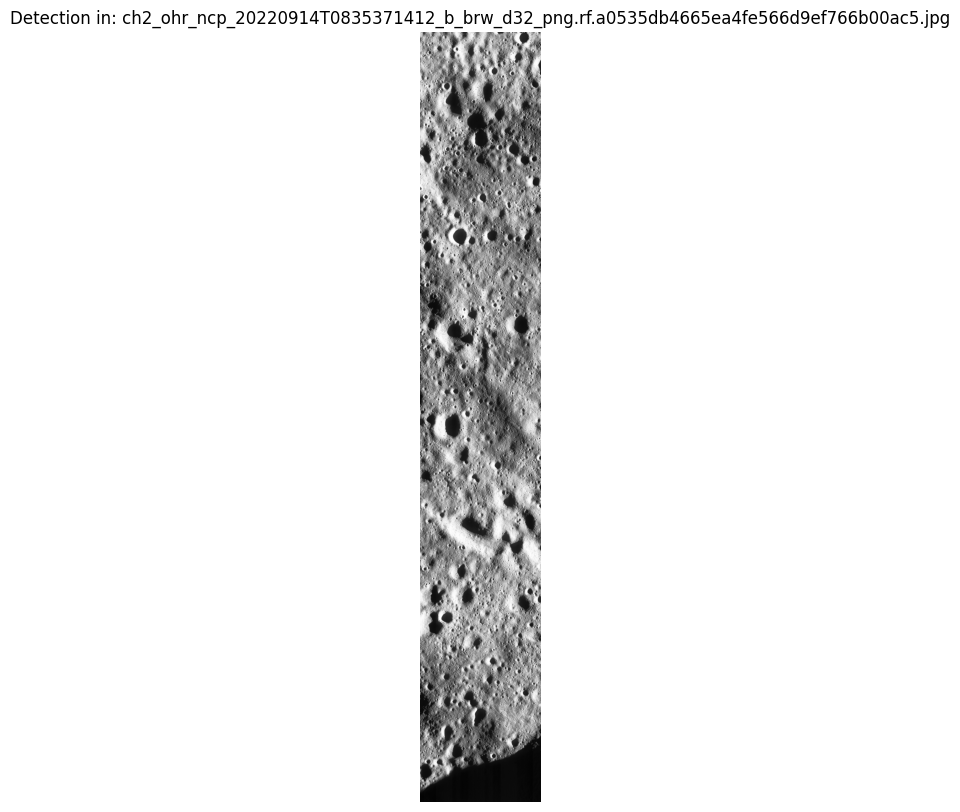

Model training, evaluation, and sample visualization completed. The trained model is saved at '/kaggle/working/best_model.pt'.


In [20]:
# Visualize sample detections
def visualize_detections(model, image_path, n_samples=10):
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = model(img_path)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)

        for result in results[0].boxes:
            x_min, y_min, x_max, y_max = result.xyxy[0].tolist()
            conf = result.conf[0].item()
            rect = plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                edgecolor="red",
                facecolor="none",
                linewidth=2,
            )
            ax.add_patch(rect)
            ax.text(
                x_min, y_min, f"{conf:.2f}", bbox=dict(facecolor="yellow", alpha=0.5)
            )

        plt.title(f"Detection in: {img_file}")
        plt.axis("off")
        plt.show()


visualize_detections(model, test_img_path)

print(
    "Model training, evaluation, and sample visualization completed. The trained model is saved at '/kaggle/working/best_model.pt'."
)

In [21]:
os.listdir(test_img_path)

['ch2_ohr_ncp_20220914T0835371412_b_brw_d32_png.rf.a0535db4665ea4fe566d9ef766b00ac5.jpg']


image 1/1 /home/abhishek/OHRC_label/test/images/ch2_ohr_ncp_20220914T0835371412_b_brw_d32_png.rf.a0535db4665ea4fe566d9ef766b00ac5.jpg: 640x128 (no detections), 15.3ms
Speed: 7.3ms preprocess, 15.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 128)


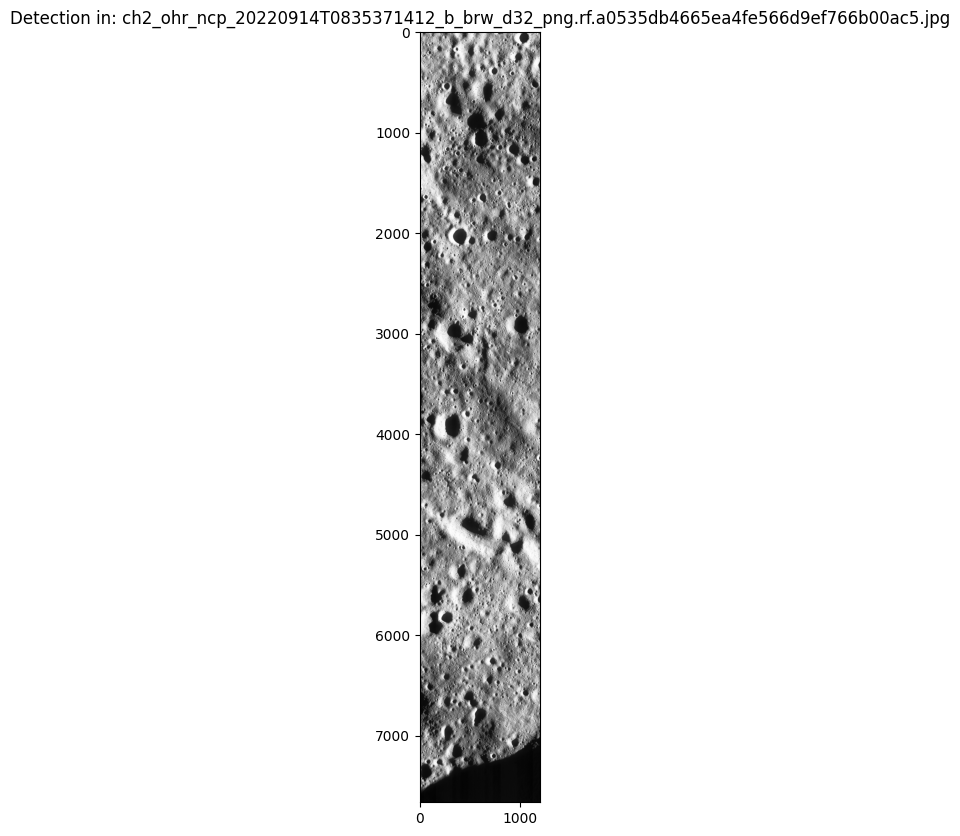

In [23]:
image_files = os.listdir(test_img_path)
for img_file in image_files:
    img_path = os.path.join(test_img_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_path)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)

    for result in results[0].boxes:
        x_min, y_min, x_max, y_max = result.xyxy[0].tolist()
        conf = result.conf[0].item()
        rect = plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            edgecolor="red",
            facecolor="none",
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f"{conf:.2f}", bbox=dict(facecolor="yellow", alpha=0.5))

plt.title(f"Detection in: {img_file}")
# plt.savefig("btest.png")


# plt.axis("off")
plt.show()

In [35]:
plt.imshow(img)